In [1]:
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install moviepy

  Using cached opencv_contrib_python-4.8.1.78-cp37-abi3-win_amd64.whl (44.8 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Zainab Shafique\\anaconda3\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [2]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import moviepy
import pandas as pd

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
DATASET_DIR = r'C:\Users\Zainab Shafique\Desktop\Human Activity Recognition\Actions'

In [4]:
CLASSES_LIST =['backflip', 'clapping','applauding','bandaging','brushing teeth','cheerleading',
           'crawling baby','crying','digging','drawing']

In [5]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20  #
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [6]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [7]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: backflip
Extracting Data of Class: clapping
Extracting Data of Class: applauding
Extracting Data of Class: bandaging
Extracting Data of Class: brushing teeth
Extracting Data of Class: cheerleading
Extracting Data of Class: crawling baby
Extracting Data of Class: crying
Extracting Data of Class: digging
Extracting Data of Class: drawing


In [8]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)
print(one_hot_encoded_labels)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [9]:
seed_constant = 10
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [10]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [11]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
    
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
      
    model.add(ConvLSTM2D(filters = 2, kernel_size = (3,3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters =4, kernel_size = (3,3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3,3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3,3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    # sigmoid is better for binary classificaitons
    model.add(Dense(len(CLASSES_LIST), activation = "sigmoid"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [12]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 2)     368       
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 2)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 2)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 4)     880       
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 4)     0         
 g3D)                                                            
                                                        

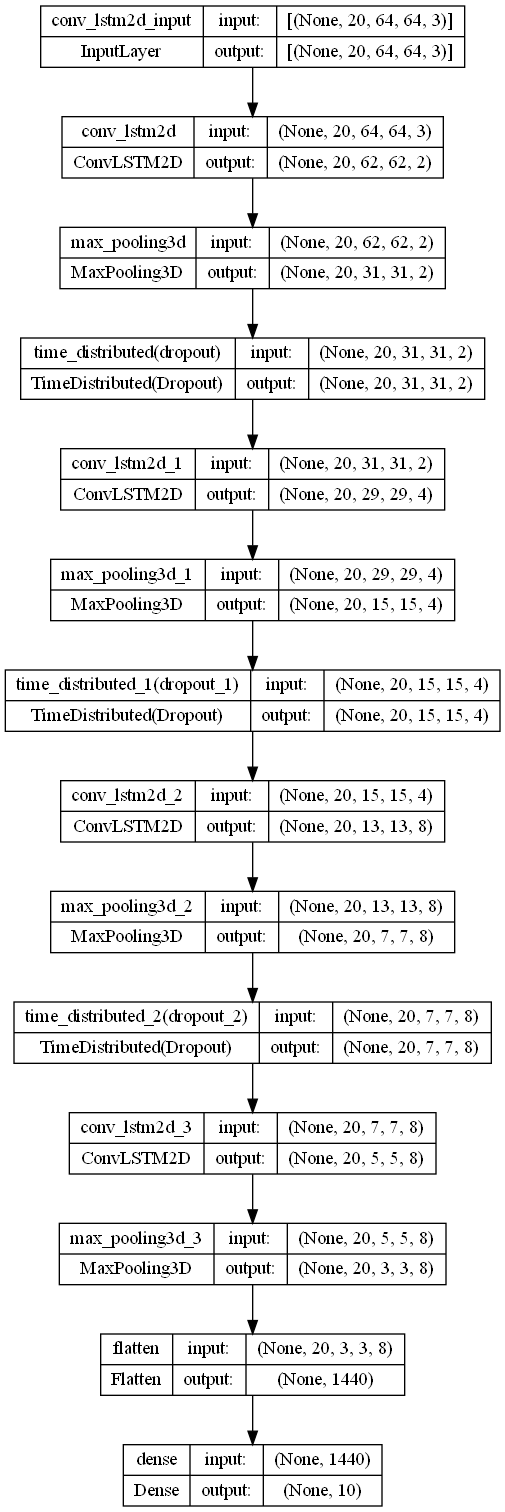

In [13]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)


In [14]:
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 2,
                                                     shuffle = True, validation_split = 0.2)

Epoch 1/50
83/83 [==============================] - 102s 1s/step - loss: 2.2253 - accuracy: 0.1152 - val_loss: 2.2859 - val_accuracy: 0.0714
Epoch 2/50
83/83 [==============================] - 85s 1s/step - loss: 2.1654 - accuracy: 0.1636 - val_loss: 2.3422 - val_accuracy: 0.1667
Epoch 3/50
83/83 [==============================] - 85s 1s/step - loss: 2.1379 - accuracy: 0.1636 - val_loss: 2.3569 - val_accuracy: 0.0952
Epoch 4/50
83/83 [==============================] - 85s 1s/step - loss: 2.1295 - accuracy: 0.1636 - val_loss: 2.3284 - val_accuracy: 0.0714
Epoch 5/50
83/83 [==============================] - 83s 1s/step - loss: 2.0934 - accuracy: 0.1879 - val_loss: 2.3053 - val_accuracy: 0.2143
Epoch 6/50
83/83 [==============================] - 82s 992ms/step - loss: 2.0719 - accuracy: 0.1939 - val_loss: 2.3370 - val_accuracy: 0.1190
Epoch 7/50
83/83 [==============================] - 85s 1s/step - loss: 2.0958 - accuracy: 0.2182 - val_loss: 2.3230 - val_accuracy: 0.1905
Epoch 8/50
83/83

In [15]:
convlstm_model.save("convlstm_model.h5")

C:\Users\Zainab Shafique\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
import cv2
import numpy as np
from collections import deque

# List of action class names.
CLASSES_LIST = ['backflip', 'clapping', 'applauding', 'bandaging', 'brushing teeth', 'cheerleading',
                'crawling baby', 'crying', 'digging', 'drawing']

# Specify the image height and width.
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH, model):
    '''
    This function will perform action recognition on a video using the ConvLSTM model.
    Args:
    video_file_path:  The path of the video stored on disk on which the action recognition is to be performed.
    output_file_path: The path where the output video with the predicted action overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    model: Pre-trained ConvLSTM model for action recognition.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video on disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'XVID'), 
                                   int(video_reader.get(cv2.CAP_PROP_FPS)), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Initialize a list to store the predicted classes for each frame in the sequence.
    predicted_classes_sequence = []

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if the frame is not read properly, then break the loop.
        if not ok:
            break

        # Resize the frame to fixed dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames queue.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue is equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis=0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

            # Append the predicted class to the sequence.
            predicted_classes_sequence.append(predicted_class_name)

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write the frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

    # Combine the predicted classes from the sequence to make the final prediction.
    final_predicted_class = max(set(predicted_classes_sequence), key=predicted_classes_sequence.count)

    return final_predicted_class

# Example usage:
# Load the pre-trained model
from tensorflow.keras.models import load_model
convlstm_model = load_model("convlstm_model.h5")

# Specify the video file path, output file path, and sequence length
video_file_path = r'C:\Users\Zainab Shafique\Desktop\Human Activity Recognition\videos\slowclap.mp4'
output_file_path = r'C:\Users\Zainab Shafique\Desktop\Human Activity Recognition\result\output_slowclap.mp4'
SEQUENCE_LENGTH = 20

# Perform action recognition and get the final predicted action
final_predicted_action = predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH, convlstm_model)

print("Final Predicted Action:", final_predicted_action)


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 315ms/step


1/1 [==============================] - 0s 390ms/step
Final Predicted Action: clapping


In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from collections import deque

# Define the path to the pre-trained LRCN model.
MODEL_PATH = 'LRCN_model.h5'

# Specify the height and width to which each video frame will be resized.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# List of action class names.
CLASSES_LIST = ['backflip', 'clapping', 'applauding', 'bandaging', 'brushing teeth', 'cheerleading',
                'crawling baby', 'crying', 'digging', 'drawing']

# Load the pre-trained LRCN model.
model = load_model(MODEL_PATH)

def frames_extraction(video_path):
    '''
    This function will extract frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list.
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

def predict_action(video_path):
    '''
    This function predicts the action in a given video using the pre-trained LRCN model.
    Args:
        video_path: The path of the video in the disk, for which action prediction is needed.
    Returns:
        predicted_action: The predicted action class.
    '''

    # Extract frames from the video.
    frames = frames_extraction(video_path)

    # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
    if len(frames) == SEQUENCE_LENGTH:
        # Convert frames to a numpy array.
        frames_array = np.array(frames)

        # Expand dimensions to match the input shape of the model.
        frames_array = np.expand_dims(frames_array, axis=0)

        # Perform action prediction using the model.
        predicted_probabilities = model.predict(frames_array)[0]

        # Get the index of the class with the highest probability.
        predicted_class_index = np.argmax(predicted_probabilities)

        # Get the predicted action class.
        predicted_action = CLASSES_LIST[predicted_class_index]

        return predicted_action
    else:
        return "Video has insufficient frames for prediction."

# Specify the path to the video for which you want to perform action prediction.
video_path_to_predict = r'C:\Users\Zainab Shafique\Desktop\Human Activity Recognition\bacha.mp4'

# Perform action prediction on the video.
predicted_action = predict_action(video_path_to_predict)

# Display the predicted action.
print(f'Predicted Action: {predicted_action}')


1/1 [==============================] - 1s 669ms/step
Predicted Action: crying
